# FoPra: Maschinelles Lernen zur Klassifizierung von Sequenzdaten

**by Nick Lowack & Kien Nguyen**

<a id='0'>Table of Contents (ToC):</a>
* <a href='#1'>1. Frame the Problem and Look at the Big Picture</a>
* <a href='#2'>2. Get the Data</a>
* <a href='#3'>3. Explore the Data</a>
* <a href='#4'>4. Prepare the Data</a>
* <a href='#5'>5. Short-List Promising Models</a>
* <a href='#6'>6. Fine-Tune the System</a>
* <a href='#7'>7. Present the Solution</a>

### Param Playground

In [1]:
import random

# Change which columns to remove here
ATTR_TO_REMOVE = []

# Change threshold for choosing top models here (value should be smaller than 1.0)
TOP_MODEL_THRESHOLD = 0.66

# Change size of the test dataset used for estimating generalization error here
TEST_SIZE = 0.25

# Change random state number here
SEED = random.randint(0,100)

# Do we use stratified split or stratified shuffle split?
STRATIFIED_SHUFFLE=True

# Do we fix outlier?
FIX_OUTLIER=False

---
<a id='1'></a>
## 1. Frame the Problem and Look at the Big Picture

### 1.1 Define the objective in business terms

* *The aim of this project is to classify given Scaffolds either as Organelle or Non-Organelle.*

![Bezeichnung für die Grafik](OrganellarClassifier.png)

### 1.2 Frame the problem

* It is categorized as a Supervised, Batch, Model-based Learning Problem.

### 1.3 Choose evaluation metrics

* Precision
* Recall 
* F1-Score

### 1.4 Import necessary resources

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import altair as alt

%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import randint
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, RandomizedSearchCV, GridSearchCV, train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import average_precision_score, plot_precision_recall_curve, precision_score, recall_score, f1_score, fbeta_score, make_scorer, precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay
from sklearn import metrics

from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score


<a href='#0'>Back to ToC</a>

---
<a id='2'></a>
## 2. Get the Data

### 2.1 Get and take a quick look at the data

In [3]:
# Read the data
df = pd.read_csv('result.csv',sep=",", header="infer", index_col = 0)
df.head()

,tRNA,rRNA,rRNAp,Mito,Plastid,GC,GC-dev,GC-out,Len,MD,PD,Organelle
Scaffold,,,,,,,,,,,,
NC_018792.1,0,1,1,25,25,34.98,12.37,1,24.92,10.03,10.03,1
NC_026751.1,1,0,0,69,73,48.16,0.81,0,1399.50,0.49,0.52,0
NC_026756.1,1,0,0,51,0,48.23,0.89,0,774.06,0.66,0.00,0
NC_026747.1,0,0,0,67,75,48.14,0.80,0,1575.14,0.43,0.48,0
NC_026746.1,1,5,1,50,0,48.24,0.90,0,1621.68,0.31,0.00,0


In [4]:
# Print a concise summary of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2148 entries, NC_018792.1 to NW_022279347.1
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tRNA       2148 non-null   int64  
 1   rRNA       2148 non-null   int64  
 2   rRNAp      2148 non-null   int64  
 3   Mito       2148 non-null   int64  
 4   Plastid    2148 non-null   int64  
 5   GC         2148 non-null   float64
 6   GC-dev     2148 non-null   float64
 7   GC-out     2148 non-null   int64  
 8   Len        2148 non-null   float64
 9   MD         2148 non-null   float64
 10  PD         2148 non-null   float64
 11  Organelle  2148 non-null   int64  
dtypes: float64(5), int64(7)
memory usage: 218.2+ KB


In [5]:
# How many samples does each label class have in the data?
print(df["Organelle"].value_counts())

0    2015
1     133
Name: Organelle, dtype: int64


In [6]:
# What is the share (proportion) of each label class in the data?
print(df["Organelle"].value_counts()/len(df))

0    0.938082
1    0.061918
Name: Organelle, dtype: float64


### 2.2 Sample and put aside a test set

In [7]:
# Split the data using stratified sampling strategy
X = df.drop("Organelle", axis=1)
y = df["Organelle"]

if not STRATIFIED_SHUFFLE:
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=TEST_SIZE)   
    #X_train, X_tmp_test, y_train, y_tmp_test = train_test_split(X, y, stratify=y, test_size=TEST_SIZE)
    #X_test, X_vali, y_test, y_vali = train_test_split(X_tmp_test, y_tmp_test, stratify=y_tmp_test, test_size=VALIDATION_SIZE)
else:
    sss = StratifiedShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=SEED)
    for train_index, test_index in sss.split(X, y):
        strat_train_set = df.iloc[train_index]
        strat_test_set = df.iloc[test_index]
    X_train = strat_train_set.drop("Organelle", axis=1)
    y_train = strat_train_set["Organelle"]
    X_test = strat_test_set.drop("Organelle", axis=1)
    y_test = strat_test_set["Organelle"]

In [8]:
# Check if the training data is evenly split
print(y_train.value_counts())
print(y_train.value_counts()/len(y_train))

0    1511
1     100
Name: Organelle, dtype: int64
0    0.937927
1    0.062073
Name: Organelle, dtype: float64


In [9]:
# Check if the test data is evenly split
print(y_test.value_counts())
print(y_test.value_counts()/len(y_test))

0    504
1     33
Name: Organelle, dtype: int64
0    0.938547
1    0.061453
Name: Organelle, dtype: float64


<a href='#0'>Back to ToC</a>

---
<a id='3'></a>
## 3. Explore the Data

### 3.1 Create a copy of the data for exploration

In [10]:
scaffolds = df.copy()

### 3.2 Study characteristics of attributes

In [11]:
# Get statistics of numerical columns
scaffolds.describe()

,tRNA,rRNA,rRNAp,Mito,Plastid,GC,GC-dev,GC-out,Len,MD,PD,Organelle
count,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000
mean,12.063315,16.139199,2.091713,75.202980,83.876629,41.868580,4.404795,0.249069,18471.577002,1.541597,1.064195,0.061918
std,47.638140,160.102982,8.112246,248.048658,301.163784,9.127534,4.891642,0.432574,40654.580861,6.280969,3.996995,0.241063
min,0.000000,0.000000,0.000000,0.000000,0.000000,9.730000,0.000000,0.000000,1.750000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,37.877500,1.030000,0.000000,66.235000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,8.000000,3.500000,41.895000,2.580000,0.000000,791.560000,0.010000,0.000000,0.000000
75%,9.000000,6.000000,2.000000,38.000000,31.250000,47.812500,6.422500,0.000000,19496.157500,0.190000,0.262500,0.000000
max,1473.000000,5630.000000,203.000000,2820.000000,3322.000000,73.080000,32.840000,1.000000,283098.400000,116.710000,89.290000,1.000000


In [12]:
def plot_count_histogram_of(feature, df):
    """
    A function that plots histograms of the given feature for each label class.
    The x-axes in the first-row histograms depicts the value range of the given feature of Organelle scaffolds.
    """
    
    df_no = df[df["Organelle"]==0]
    df_yes = df[df["Organelle"]==1]
    
    
    df_yes_feature_min = df_yes[feature].min()
    df_yes_feature_max = df_yes[feature].max()
    width = (df_yes_feature_max-df_yes_feature_min)/len(df_yes[feature].unique())
#     nr_of_df_no_samples_in_df_yes_feature_range = len(df_no[(df_no[feature]<=df_yes_feature_max) & (df_no[feature]>=df_yes_feature_min)])
    
    
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 14))
    sns.histplot(data=df_no, x=feature, ax=axes[0][0], color='steelblue', binwidth=width)
    sns.histplot(data=df_yes, x=feature, ax=axes[0][1], color='darkorange', binwidth=width)
    sns.histplot(data=df_no, x=feature, ax=axes[1][0], color='steelblue', bins=50)
    
    
    xlabel = "Organelle Scaffolds's "+ feature + " range of values"
    
    axes[0][0].set_ylabel('#Scaffold')
    axes[0][0].set_xlabel(xlabel)
    axes[0][0].set_title('Non-Organelle')
    axes[0][0].axis(xmin=0,xmax=df_yes_feature_max)
#     axes[0][0].axis(ymin=0,
#                     ymax=max(df_no[(df_no[feature]<=df_yes_feature_max) & (df_no[feature]>=df_yes_feature_min)].value_counts().to_dict().values()))
    
    axes[0][1].set_ylabel('#Scaffold')
    axes[0][1].set_xlabel(xlabel)
    axes[0][1].set_title('Organelle')
    
    axes[1][0].set_ylabel('#Scaffold')
    axes[1][0].set_xlabel("The range of values of "+feature)
    axes[1][0].set_title('Non-Organelle')
    
    fig.suptitle(feature, fontsize=20)
    fig.tight_layout()

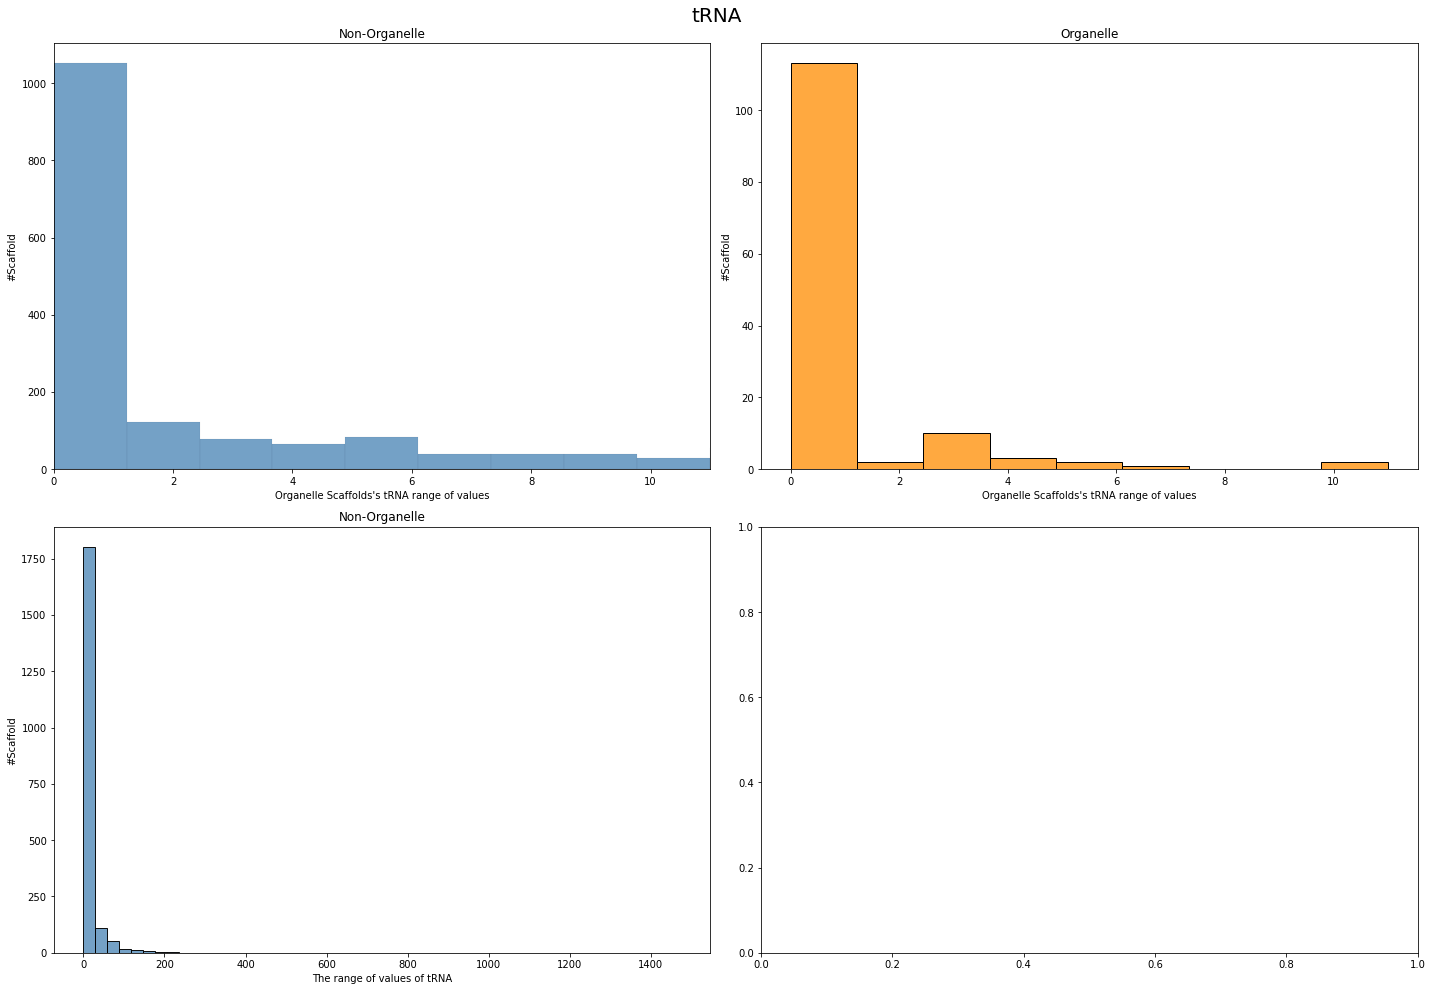

In [13]:
plot_count_histogram_of("tRNA", scaffolds)

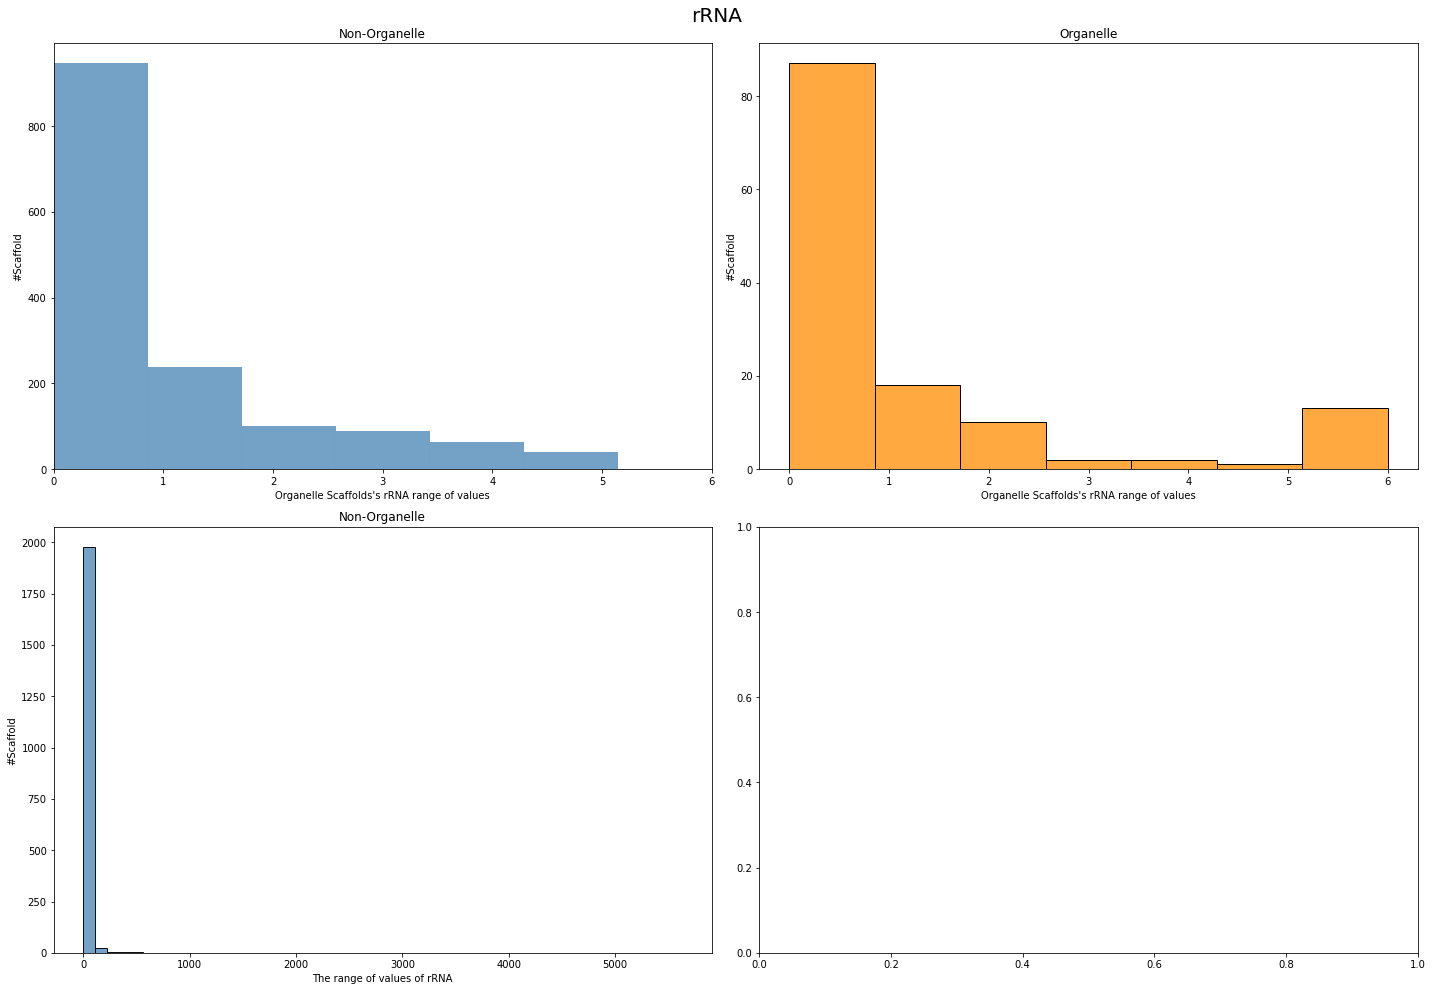

In [14]:
plot_count_histogram_of("rRNA", scaffolds)

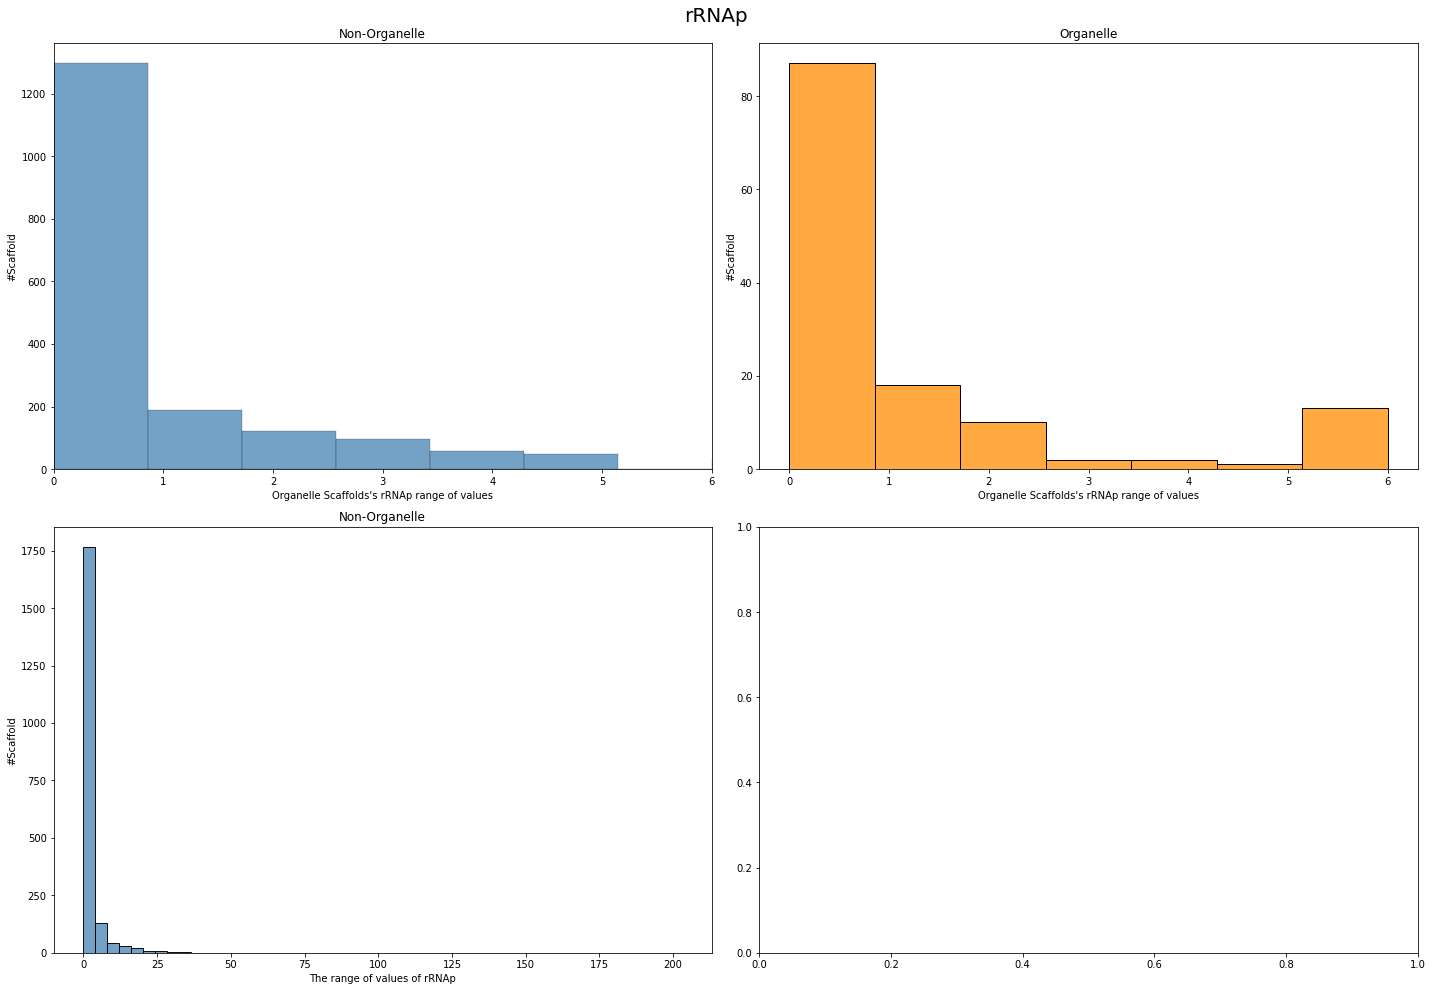

In [15]:
plot_count_histogram_of("rRNAp", scaffolds)

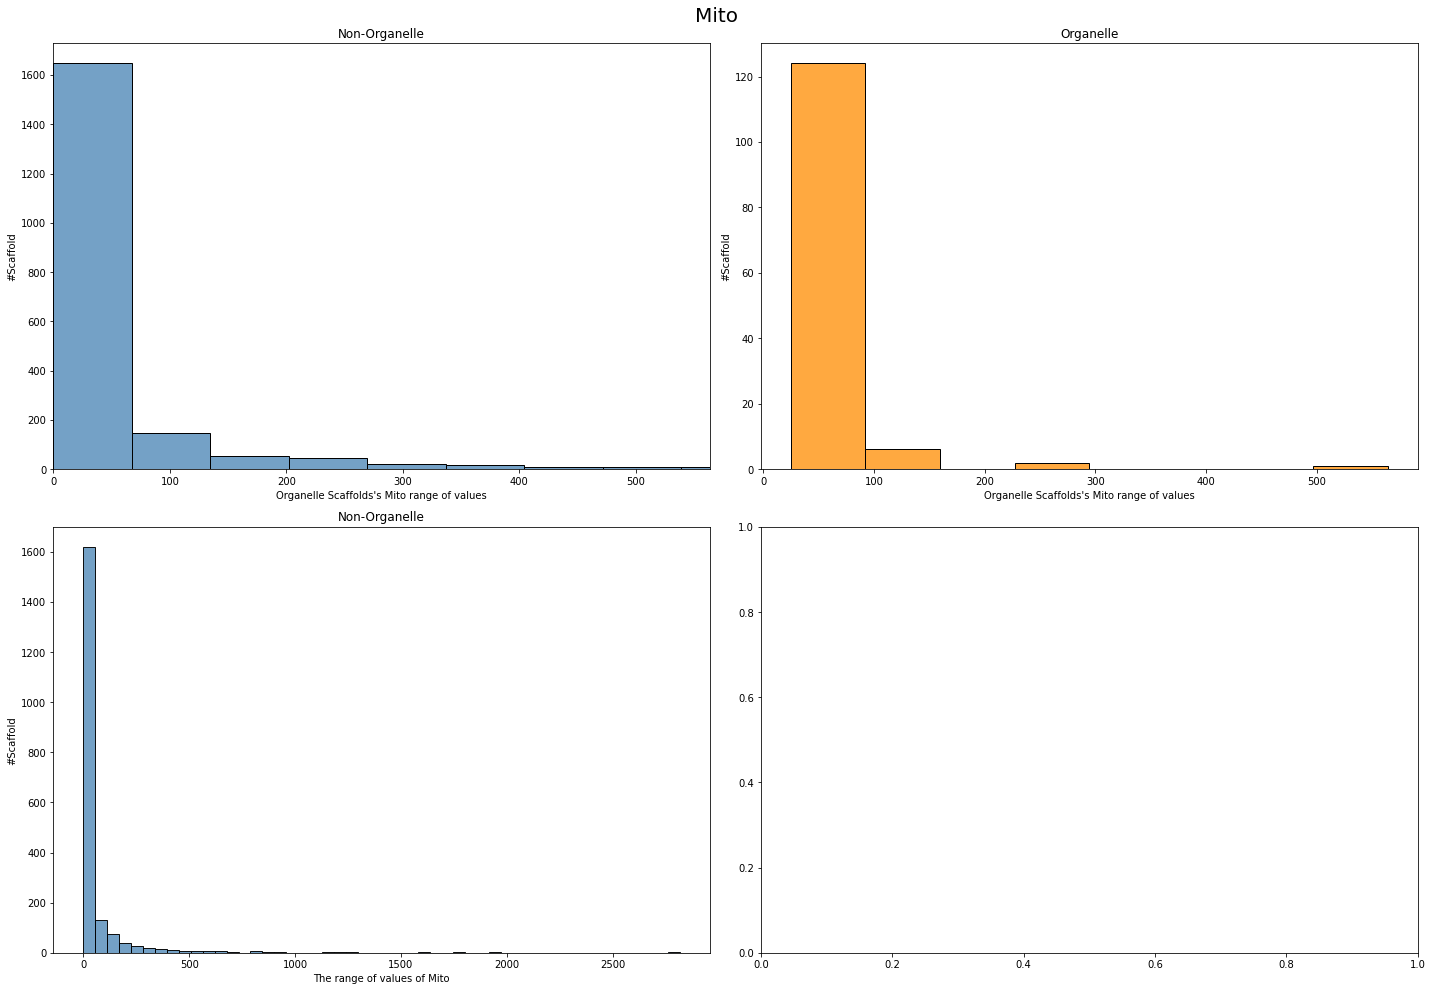

In [16]:
plot_count_histogram_of("Mito", scaffolds)

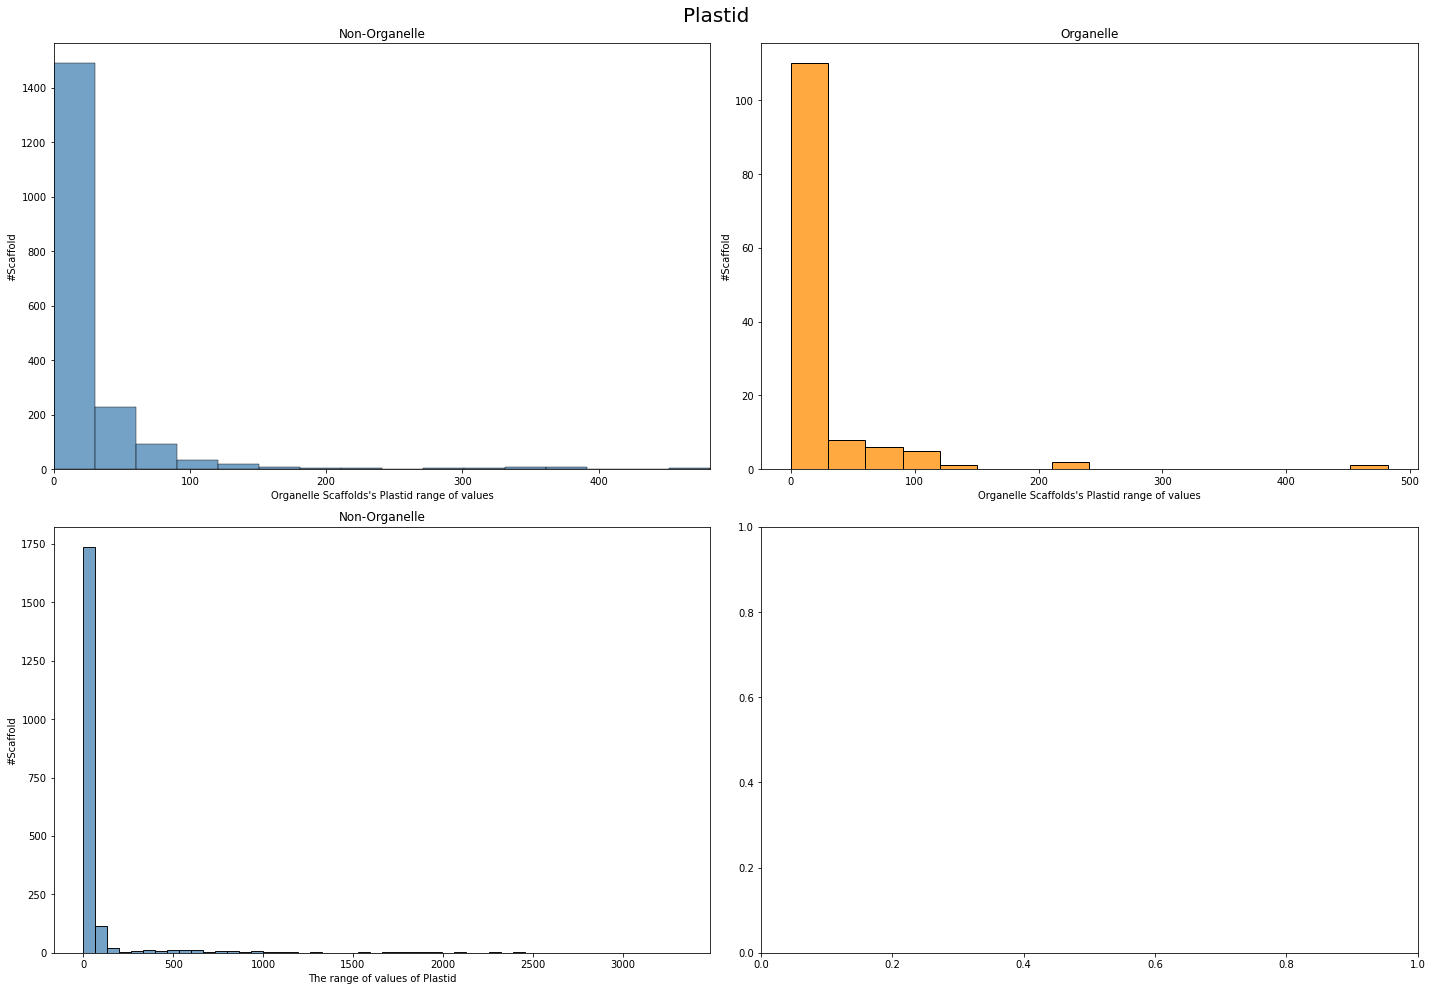

In [17]:
plot_count_histogram_of("Plastid", scaffolds)

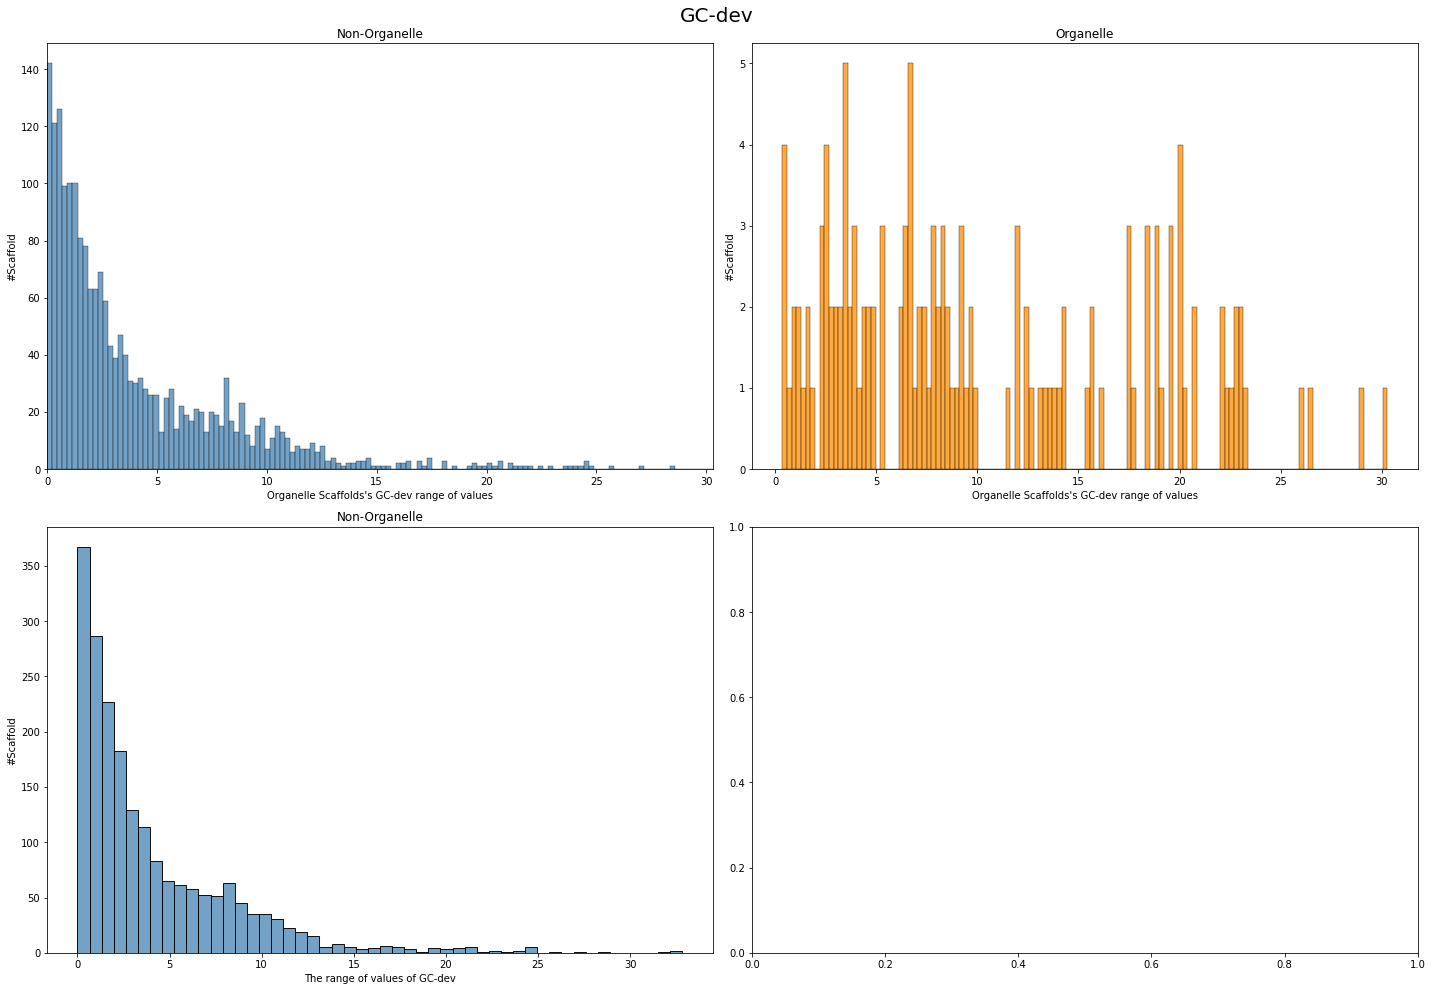

In [18]:
plot_count_histogram_of("GC-dev", scaffolds)

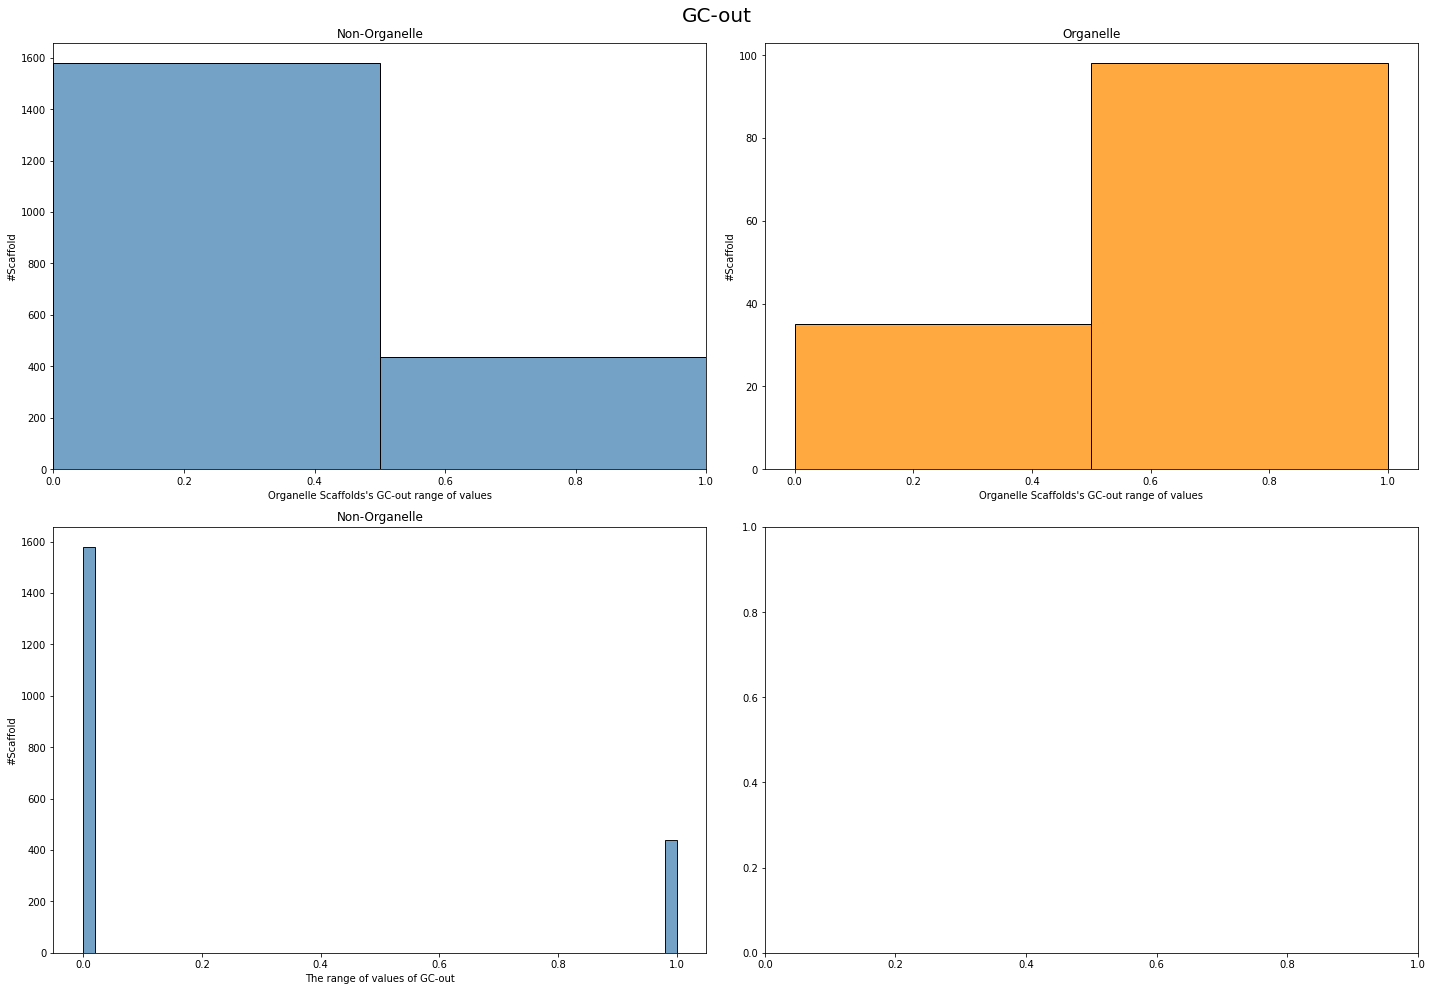

In [19]:
plot_count_histogram_of("GC-out", scaffolds)

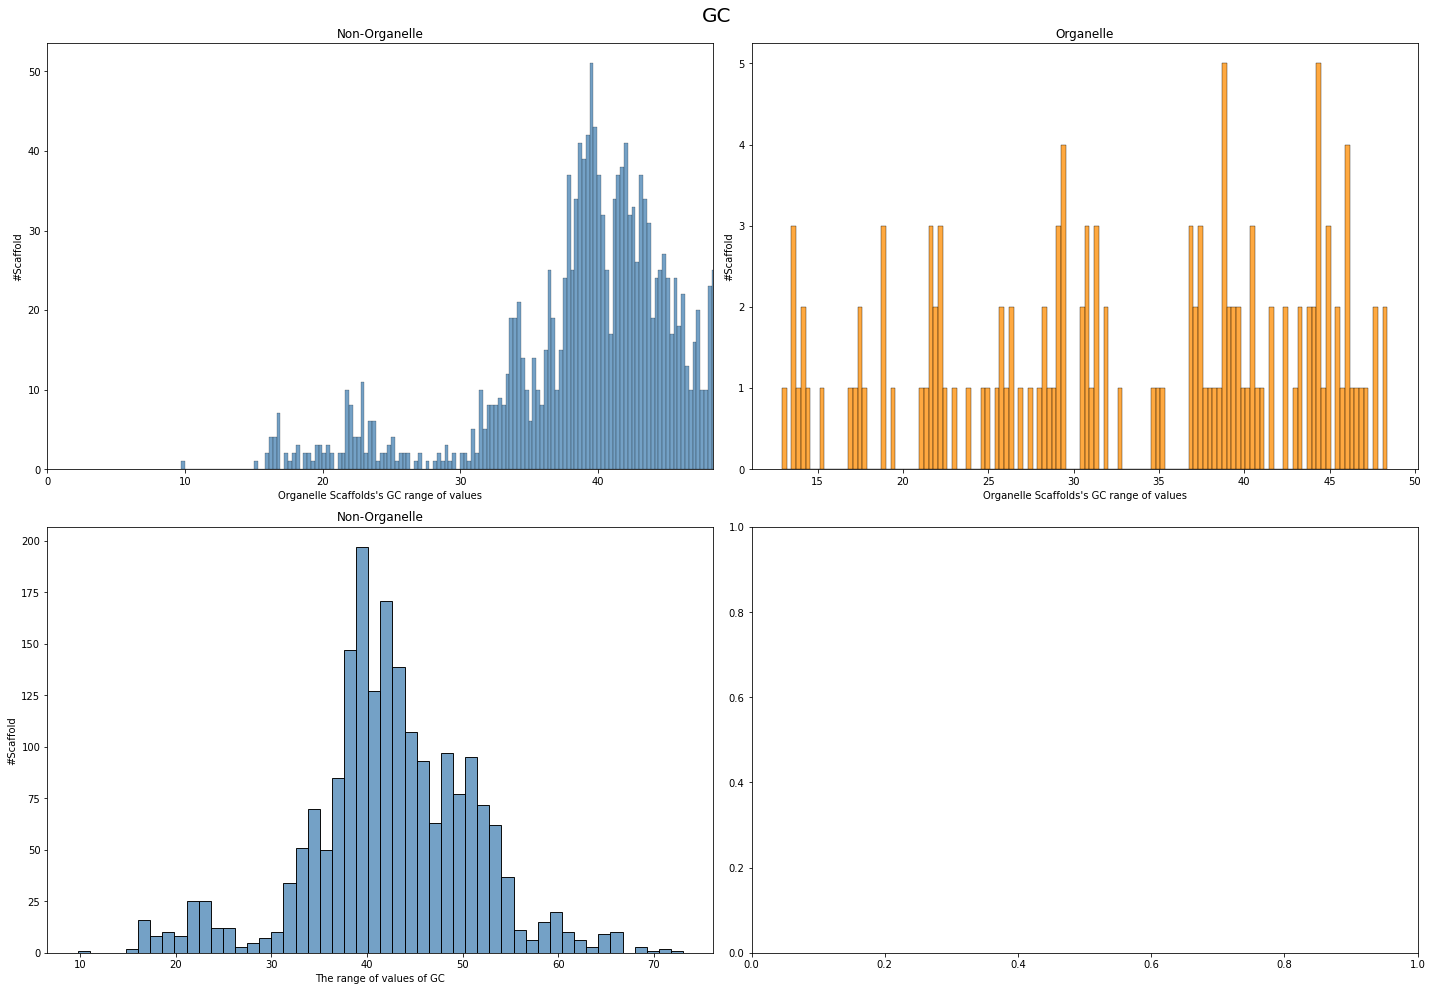

In [20]:
plot_count_histogram_of("GC", scaffolds)

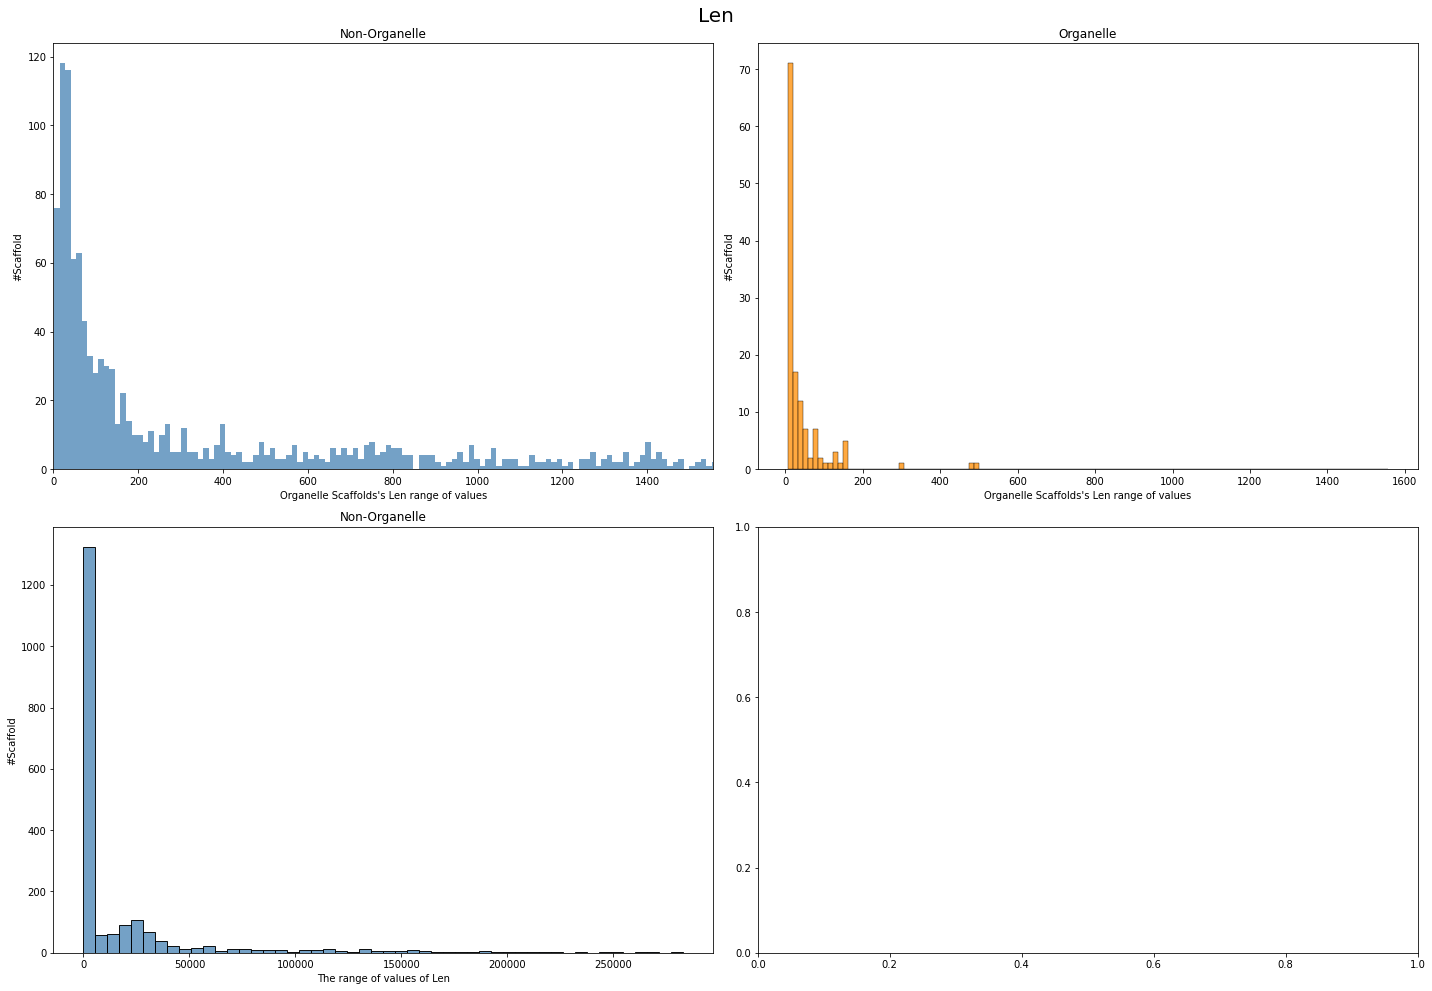

In [21]:
plot_count_histogram_of("Len", scaffolds)

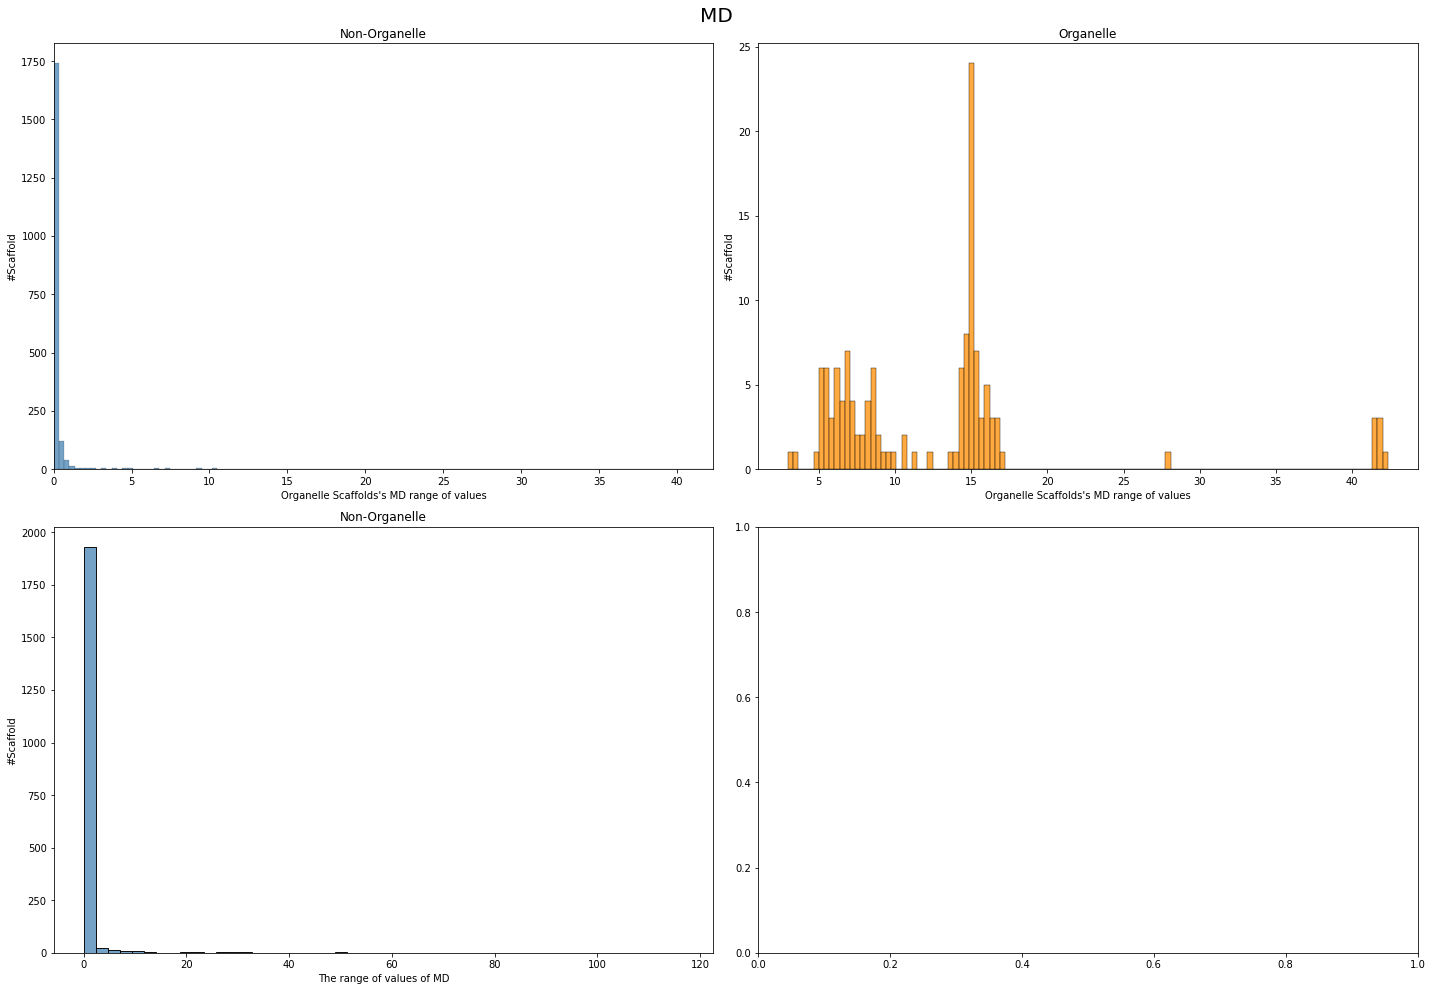

In [22]:
plot_count_histogram_of("MD", scaffolds)

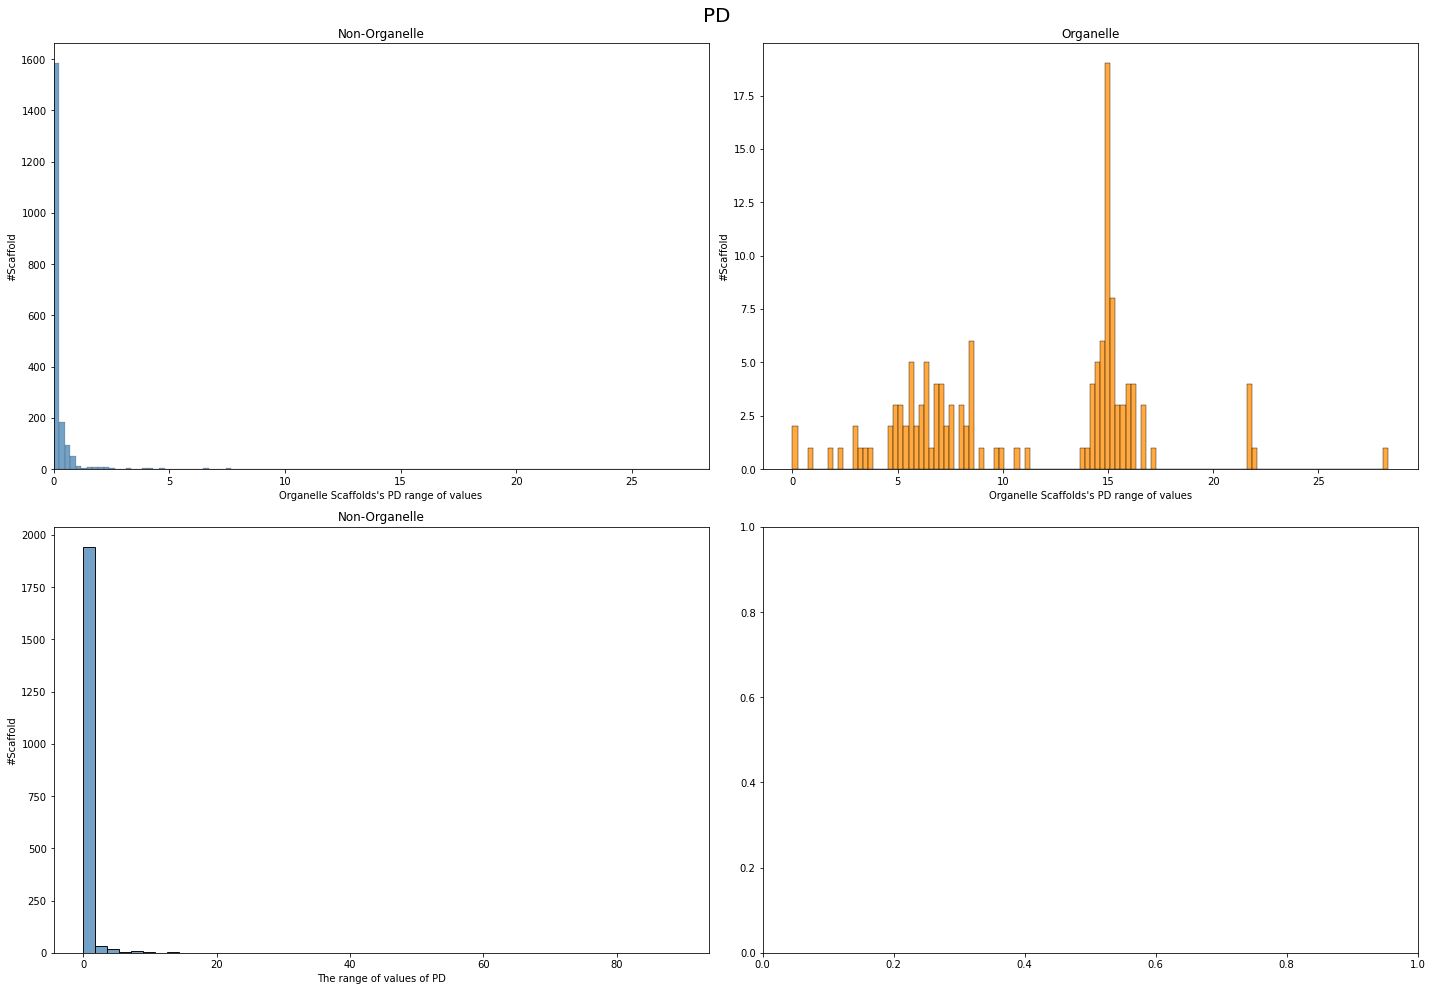

In [23]:
plot_count_histogram_of("PD", scaffolds)

### 3.3 Identify outliers and non-outliers

In [24]:
# Which scaffolds have maximum values in any of its features?
#max_indices=scaffolds.drop(["Origin","Organelle"],axis=1).idxmax(axis=0)
max_indices=scaffolds.drop(["Organelle"],axis=1).idxmax(axis=0)
scaffolds[scaffolds.index.isin(max_indices)]

,tRNA,rRNA,rRNAp,Mito,Plastid,GC,GC-dev,GC-out,Len,MD,PD,Organelle
Scaffold,,,,,,,,,,,,
NC_018792.1,0,1,1,25,25,34.98,12.37,1,24.92,10.03,10.03,1
NC_046313.1,61,4,0,2820,740,43.80,0.35,0,120754.86,0.23,0.06,0
NC_044931.1,43,1659,203,838,593,22.52,11.26,1,18351.53,0.46,0.32,0
NC_049692.1,60,5630,71,56,20,42.90,0.37,0,30917.08,0.02,0.01,0
NW_001884654.1,0,0,0,25,0,31.51,7.68,0,2.14,116.71,0.00,0
NC_052634.1,1473,128,33,5,54,50.80,1.61,0,52098.90,0.00,0.01,0
NW_101004.1,0,0,0,12,25,49.82,4.10,1,2.80,42.86,89.29,0
NC_052619.1,20,121,7,560,3322,39.37,0.86,0,74572.91,0.08,0.45,0
NC_048299.1,9,4,2,267,116,41.41,0.07,0,283098.40,0.01,0.00,0


In [25]:
# What are the indices of the outliers and non-outliers?

OUTLIER_METHOD = "Z" # "Z" or "IQR"
IQR_CONSTANT = 3
Z_THRESHOLD = 3

def get_lower_upper_bounds(datacolumn, iqr_constant):
    sorted(datacolumn)
    Q1,Q3 = np.percentile(datacolumn , [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (iqr_constant * IQR)
    upper_range = Q3 + (iqr_constant * IQR)
    return lower_range, upper_range

def get_outlier_and_nonOutlier_indices(method, data):
    #data_num = data.drop(["Len","Origin","Organelle","MD","PD"], axis=1)
    data_num = data.drop(["Len","Organelle","MD","PD"], axis=1)
    if method == "IQR":
        outlier_indices = pd.Index([])
        for col in data_num.columns:
            datacolumn = data_num[col]
            lower_bound, upper_bound = get_lower_upper_bounds(datacolumn, IQR_CONSTANT)
            outlier_indices = outlier_indices.union(data_num[(data_num[col] < lower_bound) | (data_num[col] > upper_bound)].index)
        non_outlier_indices = [x for x in df.index if x not in outlier_indices]    
    elif method == "Z":
        non_outlier_indices = data_num[(np.abs(stats.zscore(data_num)) < Z_THRESHOLD).all(axis=1)].index
        outlier_indices = [x for x in df.index if x not in non_outlier_indices]
    return outlier_indices, non_outlier_indices

outlier_indices, non_outlier_indices = get_outlier_and_nonOutlier_indices(OUTLIER_METHOD, scaffolds)

In [26]:
# How many Organelle and Non-Organelle scaffolds are left after the outliers are removed?
scaffolds[scaffolds.index.isin(non_outlier_indices)]["Organelle"].value_counts()

0    1864
1     103
Name: Organelle, dtype: int64

In [27]:
# Which of the outliers are Organelle Scaffolds?
scaffolds[scaffolds.index.isin(outlier_indices) & scaffolds["Organelle"]==1]

,tRNA,rRNA,rRNAp,Mito,Plastid,GC,GC-dev,GC-out,Len,MD,PD,Organelle
Scaffold,,,,,,,,,,,,
NC_011395.1,0,2,2,25,25,22.01,19.49,1,35.11,7.12,7.12,1
NW_019223693.1,0,1,1,25,25,13.93,7.91,1,29.40,8.50,8.50,1
NC_001224.1,0,0,0,50,25,17.11,20.06,1,85.78,5.83,2.91,1
NC_046603.1,0,0,0,25,25,21.53,23.14,1,16.12,15.51,15.51,1
NC_008290.1,2,2,2,25,25,38.22,19.17,1,44.24,5.65,5.65,1
NW_023336274.1,0,1,1,25,25,30.51,19.49,1,30.95,8.08,8.08,1
NW_003307477.1,0,1,1,25,25,28.30,22.71,1,42.45,5.89,5.89,1
NC_023293.1,0,1,1,25,25,13.69,9.41,1,29.62,8.44,8.44,1
NW_008751656.1,0,2,2,25,25,25.88,23.14,1,26.00,9.61,9.61,1


### 3.4 Study the correlations between attributes

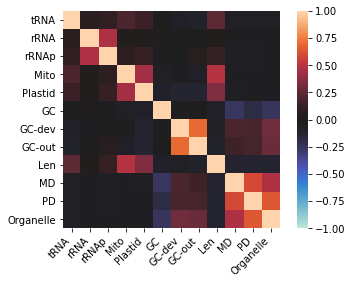

In [28]:
# Heatmap
ax = sns.heatmap(scaffolds.corr(), vmin=-1, vmax=1, center=0, square=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

In [29]:
# Correlation coefficients of all columns to "Organelle" in descending order
scaffolds.corr()['Organelle'].sort_values(ascending=False)

Organelle    1.000000
PD           0.648387
MD           0.473656
GC-dev       0.309722
GC-out       0.289765
rRNA        -0.024275
rRNAp       -0.034106
Mito        -0.035683
Plastid     -0.039607
tRNA        -0.061544
Len         -0.116397
GC          -0.247226
Name: Organelle, dtype: float64

### 3.5 Document what you have learned

* **Irrelevantes Attribut**: Das Attribut "Origin" ist für die Klassifizierungsaufgabe irrelevant und sollte daher entfernt werden.
* **Ausreißer**: Die Entfernung der Ausreißer der ganzen Daten führt zu der Entfernung von 14 Organelle-Scaffolds.
* **Attribute mit niedrigen Korrelationen zur Spalte "Organelle"**: Obwohl die Korrelationskoeffizienten von "tRNA" und "rRNAp" trivial sind, kann man aus biologischen Hintergrund die beiden nicht entfernen.

### 3.6 Identify promising transformations to apply

* Drop "Origin"
* Fix Outliers in all columns except "Len" (Optional)
* Standardize all attributes

<a href='#0'>Back to ToC</a>

---
<a id='4'></a>
## 4. Prepare the Data

In [30]:
# Work on copies of the training data
scaffolds_predictors = X_train.copy()
scaffolds_label = y_train.copy()

### 4.1 Feature selection

In [31]:
# List attributes that need to be removed
attributes_to_remove = ATTR_TO_REMOVE

In [32]:
# Define a function that remove those attributes
def remove_attr(data, attr_to_remove=attributes_to_remove, remove_attr=True):
    if remove_attr:
        return data.drop(attr_to_remove, axis=1)
    else:
        return data

### 4.2 Data cleaning

In [33]:
# List all attributes that will be excluded when searching for outliers
excluded_attributes = ["Len"]

# define a threshold for calculating Z-Score
z_threshold = 3

In [34]:
# Define a function that replaces outlier values with those that are three Standard Deviations away from the Mean
def replace_outlier(val, mean, std, z_thresh):
    if val > mean + z_thresh*std:
        return mean + z_thresh*std 
    elif val < mean - z_thresh*std:
        return mean - z_thresh*std
    return val

In [35]:
# Define a function that fixes outliers (by replacing them with other statistical values)
# Since after removing "Origin" our data will contain only numerical attr, we do not need to filter out categorical attr
def fix_outliers(data, excluded_attr=excluded_attributes, fix_outlier=FIX_OUTLIER, z_thresh=z_threshold):
    if fix_outlier:
        data_filtered = data.drop(excluded_attr, axis=1)
        data_excluded = data[excluded_attr]
        for col in data_filtered.columns:
            mean = data_filtered[col].mean()
            std_dev = data_filtered[col].std(axis=0)
            data_filtered[col] = data_filtered[col].map(lambda x: replace_outlier(x, mean, std_dev, z_thresh))
        return data_filtered.merge(data_excluded, left_index=True, right_index=True)
    else:
        return data

### 4.3 Feature scaling

A function that standardizes features is already available from [```sklearn.preprocessing.StandardScaler()```](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

### 4.4 Transformation Pipeline

In [36]:
# Define a pipeline that transforms the predictor data after the steps (functions) listed above
# Activation Vector: 1-0-1
full_pipeline = Pipeline([
      ('attr_remover', FunctionTransformer(remove_attr, validate=False)),
      ('outlier_fixer', FunctionTransformer(fix_outliers, validate=False)),
      ('std_scaler', StandardScaler())
   ])

In [37]:
# Transform the training predictor data
scaffolds_predictors_prepared = full_pipeline.fit_transform(scaffolds_predictors)

In [38]:
# Dimensions of the data after transformation
scaffolds_predictors_prepared.shape

(1611, 11)

<a href='#0'>Back to ToC</a>

---
<a id='5'></a>
## 5. Shortlist Promising Models

### 5.1 Train many quick and dirty models from different categories

In [39]:
# Initialize a lookup dictionary for the models
models: dict = {
        "AdaBoost": AdaBoostClassifier(random_state=SEED),
        "Bagging": BaggingClassifier(random_state=SEED),
        "Decision Tree": DecisionTreeClassifier(random_state=SEED),
        "Extra Trees": ExtraTreesClassifier(random_state=SEED),
        "Gradient Boosting": GradientBoostingClassifier(random_state=SEED),
        "KNeighbors": KNeighborsClassifier(),
        "Random Forest": RandomForestClassifier(random_state=SEED)
    }
searches: dict = {
    "grid": {
        "AdaBoost": {
            'base_estimator': [DecisionTreeClassifier()],
            'n_estimators': [25, 50, 200, 350, 500, 650, 800],
            'learning_rate': [0.5, 1., 1.5, 2.]
        },
        "Bagging": {
            'base_estimator': [DecisionTreeClassifier()],
            'n_estimators': [50, 250, 500, 800],
            'max_samples': [0.25, 0.5, 0.75, 1.],
            'max_features': [0.25, 0.5, 0.75, 1.],
            'bootstrap': [True, False]
        },
        "Decision Tree": {
            'criterion': ["gini","entropy"],
            'max_depth': [5,10,20,40,80],
            'min_samples_split': [2,5,7],
            'min_samples_leaf': [1,4,7]
        },
        "Extra Trees": {
            'n_estimators': [50, 250, 500, 800],
            'max_depth': [5,10,20,40,80],
            'min_samples_split': [2,5,7],
            'min_samples_leaf': [1,4,7]
        },
        "Gradient Boosting": {
            'n_estimators': [50, 250, 500, 800],
            'max_depth': [5,10,20,40,80],
            'min_samples_split': [2,5,7],
            'min_samples_leaf': [1,4,7]
        },
        "KNeighbors": {
            "n_neighbors": [3,5,7,9],
            "leaf_size": [10,20,30,40,50],
        },
        "Random Forest": {
            'n_estimators': [50, 250, 500, 800],
            'max_depth': [5,10,20,40,80],
            'min_samples_split': [2,5,7],
            'min_samples_leaf': [1,4,7]
        }
    },
    "rnd": {
        "AdaBoost": {
            'base_estimator': [DecisionTreeClassifier()],
            'n_estimators': randint(low=25, high=800),
            'learning_rate': [0.5, 1., 1.5, 2.]
        },
        "Bagging": {
            'base_estimator': [DecisionTreeClassifier()],
            'n_estimators': randint(low=10, high=801),
            'max_samples': [0.25, 0.5, 0.75, 1.],
            'max_features': [0.25, 0.5, 0.75, 1.],
            'bootstrap': [True, False]
        },
        "Decision Tree": {
            'criterion': ["gini","entropy"],
            'max_depth': randint(low=2, high=81),
            'min_samples_split': randint(low=2, high=8),
            'min_samples_leaf': randint(low=1, high=8)
        },
        "Extra Trees": {
            'n_estimators': randint(low=50, high=801),
            'max_depth': randint(low=2,high=81),
            'min_samples_split': randint(low=2, high=8),
            'min_samples_leaf': randint(low=1, high=8)
        },
        "Gradient Boosting":{
            'n_estimators': randint(low=50, high=801),
            'max_depth': randint(low=2,high=81),
            'min_samples_split': randint(low=2, high=8),
            'min_samples_leaf': randint(low=1, high=8)
        },
        "KNeighbors": {
            "n_neighbors": randint(low=3, high=9),
            "leaf_size": randint(low=10, high=50),
        },
        "Random Forest": {
            'n_estimators': randint(low=50, high=801),
            'max_depth': randint(low=2,high=81),
            'min_samples_split': randint(low=2, high=8),
            'min_samples_leaf': randint(low=1, high=8)
        }
    }
}

search_best_estimator: dict = {}
search_cv_result: dict = {}
    
for x in searches.keys():
    search_best_estimator.update({x: {m: None} for m in models})
    search_cv_result.update({x: {m: None} for m in models})

### 5.2 Measure and compare their performance

* For each model, use stratified k-fold cross validation to split the given data and measure the performance of the model on the k folds
* The final score of each model will be the average of the performance measurements on all k folds

In [40]:
# Define a function that measures the performance of the given model on the k folds split from the given data
def performance_score(model, features, label, k_fold=5):
    precision_scores, recall_scores, f1_scores, predictions, avs_scores = [], [], [], [], []
    skf = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=SEED)
    X = features
    y = label.values
    for train_index, test_index in skf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        predictions.append(y_predict)    
        precision_scores.append(precision_score(y_test,y_predict))
        recall_scores.append(recall_score(y_test,y_predict))
        f1_scores.append(f1_score(y_test,y_predict))
        avs_scores.append(average_precision_score(y_test, y_predict))
    return precision_scores, recall_scores, f1_scores, predictions, avs_scores

In [41]:
# Define a function that calculates the final score of each model
def model_scores(pos_models, features, label):
    precision_means, recall_means, f1_means, avs_means = [], [], [], []
    for model in pos_models.values():
        precisions, recalls, f1s, preds, avs = performance_score(model, features, label)
        precision_means.append(np.array(precisions).mean())
        recall_means.append(np.array(recalls).mean())
        f1_means.append(np.array(f1s).mean())
        avs_means.append(np.array(avs).mean())
    result = pd.DataFrame({"Model":pos_models.keys(), "Precision":precision_means, "Recall":recall_means, "F1-Score":f1_means, "APS": avs_means})
    return result

In [42]:
# Ignore warnings to have a clearer output
import warnings
warnings.filterwarnings('ignore')

# Measure performance of all models
measured_performance = model_scores(models, scaffolds_predictors_prepared, scaffolds_label)

In [43]:
# Ranking models from best to worst using F1-score
measured_performance.sort_values(by="F1-Score", ascending=False)

,Model,Precision,Recall,F1-Score,APS
3,Extra Trees,0.912136,0.92,0.915033,0.844126
6,Random Forest,0.879250,0.92,0.897606,0.813512
2,Decision Tree,0.894156,0.90,0.896036,0.813086
0,AdaBoost,0.879950,0.91,0.893013,0.808970
5,KNeighbors,0.879661,0.91,0.892187,0.805047
1,Bagging,0.890638,0.89,0.888827,0.800071
4,Gradient Boosting,0.885015,0.88,0.881371,0.787368


[Was bedeuten die obigen Warnungen?](https://stackoverflow.com/questions/54150147/classification-report-precision-and-f-score-are-ill-defined)

### 5.3 Get the top models

In [44]:
# Define a function that returns models whose performances measured in the given metric are higher than the given threshold 
def get_top_models(models, measured_performance, metric, threshold):
    top_performance = measured_performance[measured_performance[metric] > threshold]
    top_models = {}
    for name in top_performance["Model"].values:
        top_models[name] = models[name]
    return top_models

In [45]:
top_models = get_top_models(models, measured_performance, "F1-Score", TOP_MODEL_THRESHOLD)

<a href='#0'>Back to ToC</a>

---
<a id='6'></a>
## 6. Fine-Tune the System

### 6.1 Fine-tune the hyperparameters using cross-validation

* Treat your data transformation choices as hyperparameters, especially when you are not sure about them
* Unless there are very few hyperparameter values to explore, prefer random search over grid search

In [46]:
# Define the parameters for Randomized & Grid Search
RND_SEARCH_N_ITER = 100
CV_FOLDS = 20
test_scorer = make_scorer(fbeta_score, beta=1)

In [47]:
# Define a function that prints out the scores (and hyperparameters) of all estimators in the randomized search
def print_cv_scores(cvres):
    for rank_score, mean_score, params in zip(cvres["rank_test_score"], cvres["mean_test_score"], cvres["params"]):
        print("#" + str(rank_score) + ": " + "%.4f" % mean_score)

In [48]:
# Perform RandomizedSearchCV and GridSearchCV
for model_name, model in models.items():
    for search in searches.keys():
        print("%s %s" % (model_name, search))
        if search == "grid":
            search_cls = GridSearchCV(
                models[model_name],
                param_grid=searches[search][model_name],
                cv=CV_FOLDS, 
                scoring=test_scorer,
                n_jobs = -1
            )
        elif search == "rnd":
            search_cls = RandomizedSearchCV(
                models[model_name], 
                param_distributions=searches[search][model_name],
                n_iter=RND_SEARCH_N_ITER, 
                cv=CV_FOLDS, 
                scoring=test_scorer,
                n_jobs = -1
            )
        search_fit = search_cls.fit(scaffolds_predictors_prepared, scaffolds_label)
        search_cv_result[search][model_name] = search_fit.cv_results_
        search_best_estimator[search][model_name] = search_fit.best_estimator_

AdaBoost grid
AdaBoost rnd
Bagging grid
Bagging rnd
Decision Tree grid
Decision Tree rnd
Extra Trees grid
Extra Trees rnd
Gradient Boosting grid
Gradient Boosting rnd
KNeighbors grid
KNeighbors rnd
Random Forest grid
Random Forest rnd


### Comparison

In [49]:
comparison_graph = pd.DataFrame(columns=["F1-Score","Model","Optimization"])

for cv in search_cv_result.keys():
    for m in search_cv_result[cv].keys():
        opt = search_cv_result[cv][m]
        for rank_score, mean_score, params in zip(opt["rank_test_score"], opt["mean_test_score"], opt["params"]):
            comparison_graph = comparison_graph.append({"F1-Score": float("%.2f" % mean_score), "Model": m + " " + cv, "Optimization": cv}, ignore_index=True)

alt.Chart(comparison_graph).transform_density(
    'F1-Score',
    as_=['F1-Score', 'density'],
    extent=[0, 1],
    groupby=['Model']
).mark_area(orient='horizontal').encode(
    y='F1-Score:Q',
    color='Model:N',
    x=alt.X(
        'density:Q',
        stack='center',
        impute=None,
        title=None,
        axis=alt.Axis(labels=False, values=[0],grid=False, ticks=True),
    ),
    column=alt.Column(
        'Model:N',
        header=alt.Header(
            titleOrient='bottom',
            labelOrient='bottom',
            labelPadding=120,
            labelAngle=270
        ),
    )
).properties(width=100).configure_facet(spacing=0).configure_view(stroke=None)

alt.Chart(...)

### 6.2 Estimate the generalization error

Do NOT tweak your model after measuring the generalization error due to risk of overfitting the test set

In [50]:
# Work on copies of the test data
test_scaffolds_predictors = X_test.copy()
test_scaffolds_label = y_test.copy()

# Transform the test predictor data
test_scaffolds_predictors_prepared = full_pipeline.fit_transform(test_scaffolds_predictors)     

<a href='#0'>Back to ToC</a>

---
<a id='7'></a>
## 7. Present the Solution: Precision-Recall-Curves

In [51]:
all_model_vars = [top_models, search_best_estimator["grid"], search_best_estimator["rnd"]]
best_values: dict = {
    "aps": 0.0,
    "f1": 0.0,
}
best = None

for model_name in models.keys():
    cvs: list = []
    solutions: list = []
    print("# %s:" % model_name)
    
    for model_classes in range(0, len(all_model_vars)):
        model = all_model_vars[model_classes][model_name]
        
        if model_classes == 0:
            class_name = "NHP"
        elif model_classes == 1:
            class_name = "GRI"
        elif model_classes == 2:
            class_name = "RND"
                
        f1_scores = cross_val_score(model, test_scaffolds_predictors_prepared, test_scaffolds_label, cv=10, scoring="f1", n_jobs=-1)
        avs_scores = cross_val_score(model, test_scaffolds_predictors_prepared, test_scaffolds_label, cv=10, scoring="average_precision", n_jobs=-1)
        aps_avg = sum(avs_scores)/len(avs_scores)
        f1_avg = sum(f1_scores)/len(f1_scores)
        test_pred = model.predict(test_scaffolds_predictors_prepared)
        cvs.append("%s - APS: %.3f, F1-Scores: %.3f" % (class_name, aps_avg, f1_avg))
        
        if aps_avg > best_values["aps"]:
            best_values["aps"] = aps_avg
            best_values["f1"] = f1_avg
            best = model
        
    print("10-fold Cross-Validation Evaluation")
    print("\n".join(cvs))
    print()
    print("\n".join(solutions))

# AdaBoost:
10-fold Cross-Validation Evaluation
NHP - APS: 0.967, F1-Scores: 0.875
GRI - APS: 0.777, F1-Scores: 0.867
RND - APS: 0.777, F1-Scores: 0.867


# Bagging:
10-fold Cross-Validation Evaluation
NHP - APS: 0.910, F1-Scores: 0.860
GRI - APS: 0.992, F1-Scores: 0.895
RND - APS: 0.951, F1-Scores: 0.888


# Decision Tree:
10-fold Cross-Validation Evaluation
NHP - APS: 0.802, F1-Scores: 0.881
GRI - APS: 0.781, F1-Scores: 0.767
RND - APS: 0.847, F1-Scores: 0.859


# Extra Trees:
10-fold Cross-Validation Evaluation
NHP - APS: 1.000, F1-Scores: 0.926
GRI - APS: 1.000, F1-Scores: 0.926
RND - APS: 1.000, F1-Scores: 0.926


# Gradient Boosting:
10-fold Cross-Validation Evaluation
NHP - APS: 0.970, F1-Scores: 0.899
GRI - APS: 0.983, F1-Scores: 0.905
RND - APS: 0.959, F1-Scores: 0.890


# KNeighbors:
10-fold Cross-Validation Evaluation
NHP - APS: 0.870, F1-Scores: 0.870
GRI - APS: 0.914, F1-Scores: 0.915
RND - APS: 0.886, F1-Scores: 0.881


# Random Forest:
10-fold Cross-Validation Evaluation

ExtraTreesClassifier(random_state=3)


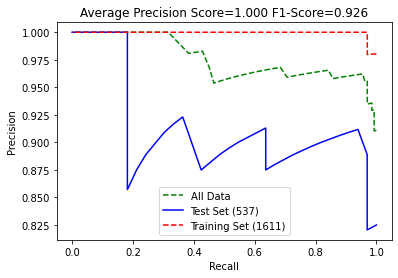

In [52]:
# Favorit on all data
all_predictors = X.copy()
all_label = y.copy()
all_predictors_prepared = full_pipeline.fit_transform(all_predictors)

if best is not None:
    print(best)
    y_scores = best.predict_proba(all_predictors_prepared)[:, 1]
    precision, recall, thresholds = precision_recall_curve(all_label, y_scores)
    fig = plt.plot(recall, precision, "g--")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Average Precision Score=%.3f F1-Score=%.3f" % (best_values["aps"], best_values["f1"]))
    
    y_scores = best.predict_proba(test_scaffolds_predictors_prepared)[:, 1]
    precision, recall, thresholds = precision_recall_curve(test_scaffolds_label, y_scores)
    plt.plot(recall, precision, "b")
    
    y_scores = best.predict_proba(scaffolds_predictors_prepared)[:, 1]
    precision, recall, thresholds = precision_recall_curve(scaffolds_label, y_scores)
    plt.plot(recall, precision, "r--")
    plt.legend(["All Data","Test Set (%d)" % len(test_scaffolds_label),"Training Set (%d)" % len(scaffolds_label)])
    plt.show()
    plt.close()
    
    """if type(best) is type(models["Random Forest"]):
        importances = best.feature_importances_
        std = np.std([tree.feature_importances_ for tree in best.estimators_], axis=0)
        forest_importances = pd.Series(importances, index=features)
        fig, ax = plt.subplots()
        forest_importances.plot.bar(yerr=std, ax=ax)
        ax.set_title("Feature importances using MDI")
        ax.set_ylabel("Mean decrease in impurity")
        fig.tight_layout()
        plt.show()
        plt.close()"""